## Вариационный автокодировщик

План на сегодня: реализуем генерацию лиц с обучением Variational autoencoder (VAE)

### Подготовим данные

Всё с прошлой практики по GAN:

In [1]:
from pathlib import Path
from typing import Callable, cast

import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
class ImageDataset(Dataset):
    def __init__(
        self,
        datadir: Path,
        transform: Callable[[Image.Image], Tensor],
        pattern: str = "*.jpg",
    ) -> None:
        self.images = list(datadir.rglob(pattern))
        self.transform = transform

    def __getitem__(self, index) -> Tensor:
        img = Image.open(self.images[index])
        return self.transform(img)

    def __len__(self) -> int:
        return len(self.images)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [ ]:
# если работаете локально или в Google Colab, укажите правильный путь до папки с изображениями
datadir = Path("/kaggle/input/celeba-dataset/img_align_celeba")
dataset = ImageDataset(
    datadir,
    transform=transform,
)
print(len(dataset))
print(dataset[0].shape)

202599
torch.Size([3, 64, 64])


In [5]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(loader))
print(batch.shape)

torch.Size([16, 3, 64, 64])


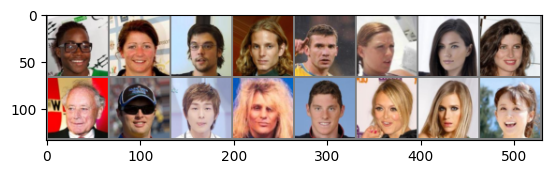

In [6]:
img_grid = torchvision.utils.make_grid(
    tensor=batch,
    nrow=8,
    padding=2,
    normalize=False,
)

plt.imshow(
    torchvision.transforms.ToPILImage()(
        img_grid * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    )
)

### Variational autoencoder

Отличный блогпост со всей математикой: https://lilianweng.github.io/posts/2018-08-12-vae/

Обычный автоэнкодер:

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png" style="background:white" width="600"/>

Вариационный автоэнкодер:

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png" style="background:white" width="600"/>

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/reparameterization-trick.png" style="background:white" width="600"/>

#### 1. Описание обучения и семплинга

Обозначения:
- $q_\phi(\mathbf{z}\vert\mathbf{x})$ — распределение энкодера
- $p_\theta(\mathbf{x}\vert\mathbf{z})$ — распределение декодера

Мы хотим максимизировать evidence lower bound (ELBO):


$\begin{aligned}
\mathcal{L}(\theta, \phi; x)
&= \log p_\theta(\mathbf{x}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}\vert\mathbf{x}) )\\
&= \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) - D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}) ) \\
\theta^{*}, \phi^{*} &= \arg\max_{\theta, \phi} \mathcal{L}(\theta, \phi; x)
\end{aligned}$

Ошибка для обучения VAE:

$L_\text{VAE}(\theta, \phi)  = - \mathcal{L}(\theta, \phi; x) = - \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) + D_\text{KL}( q_\phi(\mathbf{z}\vert\mathbf{x}) \| p_\theta(\mathbf{z}) ) \\$


В случае нормального распределения:

$$L_\text{VAE}(\theta, \phi) = \frac{1}{2c} \mathbb{E}[\lVert x - f(z) \rVert^2] + \frac{1}{2}\sum_{i = 1}^d (\sigma_{x, j}^2 + \mu_{x, j}^2 - \log \sigma_{x, j}^2 - 1)$$

Первое слагаемое — ошибка реконструкции

Второе слагаемое — регуляризация

Мы будем пользоваться ошибкой для $\beta$-VAE ([Higgins et al., 2017](https://openreview.net/forum?id=Sy2fzU9gl)):

$L_\text{BETA}(\phi, \beta) = - \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) + \beta D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x})\|p_\theta(\mathbf{z}))$

In [7]:
from lightning.pytorch.utilities.types import OptimizerLRScheduler


class VAE(L.LightningModule):
    def __init__(
        self,
        encoder: nn.Module,
        decoder: nn.Module,
        beta: float = 0.0005,
        learning_rate: float = 0.0001,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.learning_rate = learning_rate

    def training_step(self, batch: Tensor, batch_idx: int) -> None:
        # Кодируем батч
        mu, logvar = self.encoder(batch)

        # Семплируем из N(mu, var)
        eps = torch.randn_like(mu)
        z = mu + eps * torch.exp(0.5 * logvar)

        # Декодируем
        x_hat = self.decoder(z)

        # Ошибка реконструкции
        reconstruction_loss = F.mse_loss(batch, x_hat)

        # KL-дивергенция
        kl = (torch.exp(logvar) + mu**2 - logvar - 1).sum(dim=1).mean()

        # beta-VAE loss
        loss = reconstruction_loss + self.beta * kl
        self.log("reconstruction_loss", reconstruction_loss, prog_bar=True)
        self.log("kl", kl, prog_bar=True)
        return loss

    def sample(self, n: int) -> Tensor:
        device = next(self.decoder.parameters()).device
        latent_size, *_ = next(self.decoder.parameters()).data.shape
        z = torch.randn(n, latent_size, 1, 1, device=device)
        return self.decoder(z)

    def configure_optimizers(self) -> OptimizerLRScheduler:
        return torch.optim.Adam(
            self.parameters(), lr=self.learning_rate, betas=(0.5, 0.999)
        )

#### 2. Энкодер и декодер

Тоже для сравнимости возьмём что-то из практики по GAN.

Наш энкодер похож на дискриминатор для GAN, но возвращает параметры для нормального распределения: матожидание и логарифм дисперсии

А декодер - архитектурно один в один с генератором для GAN

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_size: int) -> None:
        super().__init__()
        self.latent_size = latent_size

        self.conv1 = nn.ConvTranspose2d(latent_size, 64 * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 8)
        self.conv2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 2)
        self.conv4 = nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

    def forward(self, z: Tensor) -> Tensor:
        x = z.view(-1, self.latent_size, 1, 1)  # B x C x H x W
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))


class Encoder(nn.Module):
    def __init__(self, latent_size: int) -> None:
        super().__init__()
        self.latent_size = latent_size
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 2)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 8)
        self.conv5 = nn.Conv2d(64 * 8, 2 * latent_size, 4, 1, 0, bias=False)

    def forward(self, x) -> tuple[Tensor, Tensor]:
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        x = self.conv5(x).flatten(1)
        mu = x[:, : self.latent_size]
        logvar = x[:, self.latent_size :]
        return mu, logvar

In [9]:
latent_size = 128
decoder = Decoder(latent_size)
encoder = Encoder(latent_size)

Проверим, что всё работает:

In [10]:
mu, sigma = encoder.forward(batch)
epsilon = torch.randn_like(mu, requires_grad=True)
z = mu + epsilon * sigma
print(mu.shape)
g = decoder.forward(z)
print(g.shape)

torch.Size([16, 128])
torch.Size([16, 3, 64, 64])


#### 3. Запуск обучения

Нам понадобится callback, который будет выбирать несколько изображений из датасета, реконструировать их, и генерировать несколько новых из шума. Это позволит нам визуально отслеживать степень регуляризации

In [11]:
class Generate(L.Callback):
    def __init__(self, n: int) -> None:
        super().__init__()
        self.n = n

    def on_train_epoch_end(
        self, trainer: L.Trainer, pl_module: L.LightningModule
    ) -> None:
        assert isinstance(pl_module, VAE)
        # Берём случайные примеры из обучающего датасета
        loader = DataLoader(
            trainer.train_dataloader.dataset, batch_size=self.n, shuffle=True
        )
        x = next(iter(loader)).to(device=pl_module.device)

        # Кодируем и декодируем
        mu, logvar = pl_module.encoder(x)
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(mu)
        z = eps * std + mu
        x_hat = pl_module.decoder(z)

        # Генерируем новые из шума
        z = torch.randn_like(mu)
        x_new = pl_module.decoder(z)

        # Соединяем и отрисовываем
        images = torch.cat([x, x_hat, x_new])
        grid = torchvision.utils.make_grid(
            tensor=images,
            nrow=min(self.n, 8),
            padding=2,
            normalize=True,
        )
        str_title = f"{pl_module.__class__.__name__}_images"
        logger = cast(TensorBoardLogger, pl_module.logger)
        logger.experiment.add_image(str_title, grid, global_step=pl_module.global_step)

In [ ]:
trainer = L.Trainer(
    max_epochs=200,
    logger=TensorBoardLogger(save_dir="logs", name="vae"),
    limit_train_batches=1000,
    callbacks=[Generate(n=8)],
)

latent_size = 128
lit = VAE(
    encoder=Encoder(latent_size),
    decoder=Decoder(latent_size),
    beta=0.0002,
    learning_rate=0.0001,
)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
trainer.fit(model=lit, train_dataloaders=loader)

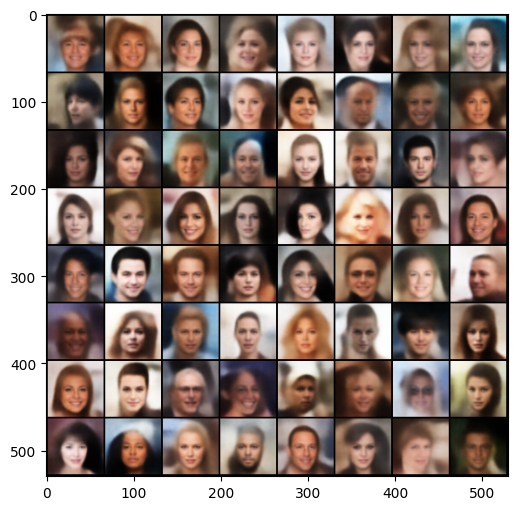

In [15]:
model_version = "version_5"
checkpoint_path = next(Path(f"logs/vae/{model_version}/checkpoints/").glob("*.ckpt"))
latent_size = 128
lit = VAE(
    encoder=Encoder(latent_size),
    decoder=Decoder(latent_size),
    beta=0.0002,
    learning_rate=0.0001,
)
lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])
images = lit.sample(n=64)
grid = torchvision.utils.make_grid(
    tensor=images,
    nrow=8,
    padding=2,
    normalize=True,
    value_range=(-1, 1),
)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(torchvision.transforms.ToPILImage()(grid))

### Упражнения

1. Сделайте интерполяцию между двумя латентными векторами и сгенерируйте изображения лиц для полученной последовательности. Вам пригодится функция `torch.lerp`. Почитайте про сферическую линейную интерполяцию (SLERP), сравните результаты с простой линейной.
2. Реализуйте VQ-VAE (https://paperswithcode.com/method/vq-vae)